In [1]:
import os
import sys
import zipfile

from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# CUR_DIR = os.path.dirname(os.path.abspath(__file__))
CUR_DIR = os.getcwd()
CUR_DIR

'/Users/fulofwrk/Documents/github/dacon_136'

In [3]:
zf = zipfile.ZipFile(os.path.join(CUR_DIR, 'data', 'train.csv.zip'))
trainDF = pd.read_csv(zf.open("train.csv"))
trainDF.sort_values(by=['date', 'time'], inplace=True)

print("# of train dataset :", len(trainDF))

# of train dataset : 3362796


In [4]:
trainDF.head(3)

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
1222519,526,2016-08-01,00:02:24,6e5c4f0747,122,NaN,0,0
1838181,942,2016-08-01,00:03:26,7265a0f4f7,23,NaN,0,0
1552590,723,2016-08-01,00:03:45,e893bec963,215,NaN,0,0


- store_id : 상점 고유 번호 (해당 기한 내 개업 혹은 폐업한 상점도 있음)
- date : 거래 일자
- time : 거래 시간
- card_id : 카드 번호의 hash 값
- amount : 매출 금액, 음수인 경우는 취소 거래
- installments : 할부 개월 수, 일시불은 빈 문자열
- days_of_week : 요일, 월요일이 0, 일요일은 6
- holiday : 1이면 공휴일, 0이면 공휴일 아님

In [5]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3362796 entries, 1222519 to 2747378
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   store_id      int64  
 1   date          object 
 2   time          object 
 3   card_id       object 
 4   amount        int64  
 5   installments  float64
 6   days_of_week  int64  
 7   holyday       int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 230.9+ MB


In [6]:
trainDF.describe()

,store_id,amount,installments,days_of_week,holyday
count,3.362796e+06,3.362796e+06,16860.000000,3.362796e+06,3.362796e+06
mean,8.323770e+02,1.459623e+02,3.459490,3.066320e+00,4.431283e-02
std,5.468544e+02,6.017306e+02,2.382382,1.976153e+00,2.057892e-01
min,0.000000e+00,-2.500000e+05,2.000000,0.000000e+00,0.000000e+00
25%,3.350000e+02,3.200000e+01,3.000000,1.000000e+00,0.000000e+00
50%,8.220000e+02,7.500000e+01,3.000000,3.000000e+00,0.000000e+00
75%,1.342000e+03,1.500000e+02,3.000000,5.000000e+00,0.000000e+00
max,1.799000e+03,2.500000e+05,36.000000,6.000000e+00,1.000000e+00


In [7]:
print("# of unique stores :", trainDF.store_id.nunique())
print("# of unique card ids :", trainDF.card_id.nunique())

# of unique stores : 1775
# of unique card ids : 922522


(array([3213781.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  149015.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

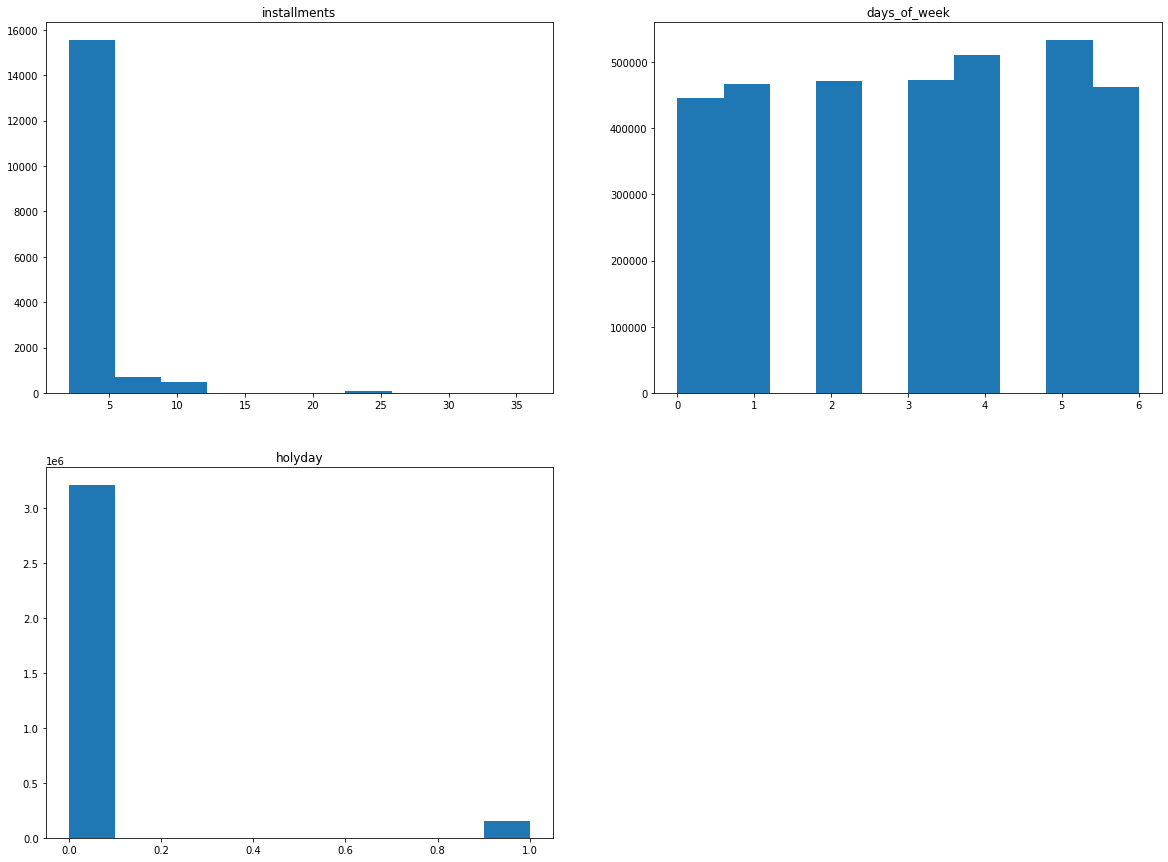

In [8]:
f = plt.figure(figsize=(20, 15))

ax = f.add_subplot(221)
ax.set_title("installments")
ax.hist(data=trainDF, x='installments')
ax2 = f.add_subplot(222)
ax2.set_title("days_of_week")
ax2.hist(data=trainDF, x='days_of_week')
ax3 = f.add_subplot(223)
ax3.set_title("holyday")
ax3.hist(data=trainDF, x='holyday')

In [9]:
# 카드별로 매출 합계 집계
perCard = trainDF.groupby(by=['card_id'], as_index=False).agg({'amount': np.sum})
perCard.loc[perCard.amount < 0] # 조회 기간 이전 거래의 취소 건으로 보여짐...

,card_id,amount
331683,5c127f94cd,-118
455054,7e74575056,-330
480616,8589f5980e,-10904
497586,8a3dc45eaa,-625
602576,a7416614f6,-2167
707166,c43fee0edb,-4980


In [10]:
tmp = deepcopy(trainDF.head(100))

tmp['moving_avg'] = tmp.groupby('card_id')['amount'].transform(lambda x: x.rolling(3, 1).mean())
tmp[tmp['card_id']=='fee8cf2e44']

# 이동평균 값을 만들려고 했으나 다음과 같은 경우가 있어, 일별 집계를 먼저 진행하는게 좋아보임...

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,moving_avg
1635378,782,2016-08-01,01:27:42,fee8cf2e44,162,NaN,0,0,162.0
1635379,782,2016-08-01,01:27:46,fee8cf2e44,-162,NaN,0,0,0.0
1635380,782,2016-08-01,01:28:05,fee8cf2e44,162,NaN,0,0,54.0


In [11]:
grouped = trainDF.groupby(
    by=['store_id', 'date', 'days_of_week', 'holyday', 'card_id'], 
    as_index=False
).agg({'amount': np.sum})
grouped.sort_values(by=['date', 'store_id', 'card_id'], inplace=True)
grouped.reset_index(drop=True, inplace=True)

print("# of groupping dataset :", len(grouped))

# of groupping dataset : 3165601


In [19]:
tmp = deepcopy(grouped.head(50000))

tmp['moving_avg'] = tmp.groupby(
    by=['store_id', 'card_id']
)['amount'].transform(lambda x: x.rolling(3, 1).mean())

tmp

,store_id,date,days_of_week,holyday,card_id,amount,moving_avg
0,2,2016-08-01,0,0,1512543aa8,40,40.0
1,2,2016-08-01,0,0,24aab27727,40,40.0
2,2,2016-08-01,0,0,29ef3873e4,42,42.0
3,2,2016-08-01,0,0,2e666eeeec,1775,1775.0
4,2,2016-08-01,0,0,32981beeb6,75,75.0
...,...,...,...,...,...,...,...
49995,268,2016-08-19,4,0,5e04c8239f,100,100.0
49996,268,2016-08-19,4,0,84c7a97d49,85,85.0
49997,268,2016-08-19,4,0,ab64ae0fc0,85,85.0
49998,268,2016-08-19,4,0,ad5b36ea11,50,50.0


In [20]:
tmp.loc[tmp['amount'] != tmp['moving_avg']]

,store_id,date,days_of_week,holyday,card_id,amount,moving_avg
2658,8,2016-08-02,1,0,42191ae921,750,1075.0
2683,22,2016-08-02,1,0,fff57c7e99,87,127.0
2698,24,2016-08-02,1,0,e0ccf0755d,11,55.5
2713,51,2016-08-02,1,0,15518cf045,52,47.5
2744,60,2016-08-02,1,0,8880b25312,410,270.0
...,...,...,...,...,...,...,...
49942,236,2016-08-19,4,0,67716fd5ab,75,70.0
49947,236,2016-08-19,4,0,9c1e3b2d8c,70,102.5
49958,236,2016-08-19,4,0,f56cd49599,30,32.5
49988,247,2016-08-19,4,0,a160d16856,80,95.0


In [21]:
grouped.head(2)

,store_id,date,days_of_week,holyday,card_id,amount
0,2,2016-08-01,0,0,1512543aa8,40
1,2,2016-08-01,0,0,24aab27727,40
